In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers

import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from baukit import nethook
from operator import itemgetter

In [4]:
MODEL_NAME = "EleutherAI/gpt-j-6B" # "facebook/galactica-6.7b"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
n_embd_field = "hidden_size"
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float16)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})

print(f"{MODEL_NAME} ==> device: {model.device}, memory: {model.get_memory_footprint()}")

EleutherAI/gpt-j-6B ==> device: cuda:0, memory: 12219206136


In [5]:
with open("data/comperative-superlative.txt") as f:
    lines = f.readlines()
    words = []
    for line in lines:
        w = line.strip()
        if(len(w) == 0):
            continue
        words.append(w)

base = words[0 : len(words) : 3]
comparative = words[1 : len(words) : 3]
superlative = words[2 : len(words) : 3]

list(zip(base, comparative, superlative))

[('angry', 'angrier', 'angriest'),
 ('bad', 'worse', 'worst'),
 ('big', 'bigger', 'biggest'),
 ('bitter', 'bitterer', 'bitterest'),
 ('black', 'blacker', 'blackest'),
 ('bland', 'blander', 'blandest'),
 ('bloody', 'bloodier', 'bloodiest'),
 ('blue', 'bluer', 'bluest'),
 ('bold', 'bolder', 'boldest'),
 ('bossy', 'bossier', 'bossiest'),
 ('brave', 'braver', 'bravest'),
 ('brief', 'briefer', 'briefest'),
 ('bright', 'brighter', 'brightest'),
 ('broad', 'broader', 'broadest'),
 ('busy', 'busier', 'busiest'),
 ('calm', 'calmer', 'calmest'),
 ('cheap', 'cheaper', 'cheapest'),
 ('chewy', 'chewier', 'chewiest'),
 ('chubby', 'chubbier', 'chubbiest'),
 ('classy', 'classier', 'classiest'),
 ('clean', 'cleaner', 'cleanest'),
 ('clear', 'clear', 'clearest'),
 ('clever', 'cleverer', 'cleverest'),
 ('close', 'closer', 'closest'),
 ('cloudy', 'cloudier', 'cloudiest'),
 ('clumsy', 'clumsier', 'clumsiest'),
 ('coarse', 'coarser', 'coarsest'),
 ('cold', 'colder', 'coldest'),
 ('cool', 'cooler', 'coolest'

In [6]:
tokenizer([' class', ' classy', ' classier', ' classiest'], padding=True, return_tensors='pt')

{'input_ids': tensor([[ 1398, 50256],
        [48486, 50256],
        [ 1398,   959],
        [ 1398,  6386]]), 'attention_mask': tensor([[1, 0],
        [1, 0],
        [1, 1],
        [1, 1]])}

In [7]:
filter_single_token = []
for b, c, s in zip(base, comparative, superlative):
    tokenized = tokenizer([" " + b, " " + c, " " + s], padding=True, return_tensors='pt').input_ids
    if(tokenized.shape[1] > 1):
        continue
    filter_single_token.append((b, c, s))
filter_single_token

[('bad', 'worse', 'worst'),
 ('big', 'bigger', 'biggest'),
 ('bright', 'brighter', 'brightest'),
 ('cheap', 'cheaper', 'cheapest'),
 ('close', 'closer', 'closest'),
 ('cool', 'cooler', 'coolest'),
 ('dark', 'darker', 'darkest'),
 ('deep', 'deeper', 'deepest'),
 ('early', 'earlier', 'earliest'),
 ('easy', 'easier', 'easiest'),
 ('fast', 'faster', 'fastest'),
 ('fine', 'finer', 'finest'),
 ('full', 'fuller', 'fullest'),
 ('good', 'better', 'best'),
 ('great', 'greater', 'greatest'),
 ('happy', 'happier', 'happiest'),
 ('hard', 'harder', 'hardest'),
 ('heavy', 'heavier', 'heaviest'),
 ('high', 'higher', 'highest'),
 ('hot', 'hotter', 'hottest'),
 ('large', 'larger', 'largest'),
 ('late', 'later', 'latest'),
 ('long', 'longer', 'longest'),
 ('low', 'lower', 'lowest'),
 ('near', 'nearer', 'nearest'),
 ('new', 'newer', 'newest'),
 ('poor', 'poorer', 'poorest'),
 ('quick', 'quicker', 'quickest'),
 ('rich', 'richer', 'richest'),
 ('safe', 'safer', 'safest'),
 ('short', 'shorter', 'shortest'),


In [8]:
prompt = """superlative of late is latest
superlative of strong is strongest
superlaitve of {} is"""

# prompt = """grape ends with E
# monitor ends with R
# glass ends with"""

words = ['strong', 'big', 'deep', 'young']

for w in words:
    txt, ret_dict = model_utils.generate_fast(
        model, tokenizer, 
        prompts=[prompt.format(w)], max_new_tokens=10, 
        get_answer_tokens=True, argmax_greedy=True
    )
    print(f"{w} ===> {ret_dict['answer'][0]['top_token']}")


strong ===>  strongest
big ===>  biggest
deep ===>  deepest
young ===>  youngest


In [9]:
objects = [" " + o[2] for o in filter_single_token]

from relations.corner import CornerEstimator
corner_estimator = CornerEstimator(
    model=model, tokenizer=tokenizer,
    # ln_f_name= "model.decoder.final_layer_norm", 
    # unembedder_module_name="lm_head"
)

In [10]:
simple_corner = corner_estimator.estimate_simple_corner(objects, scale_up=70)
print(simple_corner.norm().item(), corner_estimator.get_vocab_representation(simple_corner, get_logits=True))

51.53125 [(' largest', 104.312), (' highest', 103.062), (' longest', 99.688), (' strongest', 99.375), (' smallest', 99.125)]


In [11]:
# print(-simple_corner.norm().item(), corner_estimator.get_vocab_representation(-simple_corner, get_logits=True))

In [12]:
lin_inv_corner = corner_estimator.estimate_lin_inv_corner(objects, target_logit_value=50)
print(lin_inv_corner.norm().item(), corner_estimator.get_vocab_representation(lin_inv_corner, get_logits=True))

calculating inverse of unbedding weights . . .
48.71875 [(' strongest', 74.875), (' fastest', 73.938), (' longest', 73.375), (' largest', 72.0), (' smallest', 70.562)]


In [13]:
lst_sq_corner = corner_estimator.estimate_corner_lstsq_solve(objects[:15], target_logit=30)
print(lst_sq_corner.norm().item(), corner_estimator.get_vocab_representation(lst_sq_corner, get_logits=True))

39.90625 [(' highest', 88.875), (' largest', 88.625), (' best', 88.5), (' closest', 88.312), (' worst', 88.062)]


In [14]:
grad_dsc_corner = corner_estimator.estimate_corner_with_gradient_descent(objects, target_logit_value=50, verbose=False)
print(grad_dsc_corner.norm().item(), corner_estimator.get_vocab_representation(grad_dsc_corner, get_logits=True))

transformer.ln_f.weight torch.Size([4096]) torch.float32
transformer.ln_f.bias torch.Size([4096]) torch.float32
lm_head.weight torch.Size([50400, 4096]) torch.float32
lm_head.bias torch.Size([50400]) torch.float32


/home/local_arnab/Codes/relations/notebooks/../relations/corner.py:159: UserWarning: 
                model.dtype == torch.float16
                the unembedder head will be typecasted to float32 in order to avoid precision underflows.
                
  warnings.warn(


torch.float16
50.21875 [(' oldest', 53.438), (' richest', 52.0), (' closest', 50.875), (' fastest', 50.781), (' brightest', 50.562)]


In [15]:
def check_with_test_cases(relation_operator):
    test_cases = [
        (b, -1, s) for b, c, s in filter_single_token[15:]
    ]
    # print(test_cases)
    for subject, subject_token_index, target in test_cases:
        answer = relation_operator(
            subject,
            subject_token_index=subject_token_index,
            device=model.device,
            return_top_k=5,
        )
        print(f"{subject}, target: {target}   ==>   predicted: {answer}")

In [16]:
relation = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = prompt,
    layer = 15, 
    # layer_name_format = "model.decoder.layers.{}",
    weight = torch.eye(getattr(model.config, n_embd_field)).to(model.dtype).to(model.device),
    bias = grad_dsc_corner,

    # ln_f_name = "model.decoder.final_layer_norm"
)

check_with_test_cases(relation)

happy, target: happiest   ==>   predicted: [' smallest', ' best', ' largest', ' tallest', ' biggest']
hard, target: hardest   ==>   predicted: [' smallest', ' lowest', ' largest', ' closest', ' cheapest']
heavy, target: heaviest   ==>   predicted: [' heaviest', ' lowest', ' largest', ' smallest', ' best']
high, target: highest   ==>   predicted: [' largest', ' tallest', ' smallest', ' best', ' greatest']
hot, target: hottest   ==>   predicted: [' largest', ' lowest', ' highest', ' best', ' tallest']
large, target: largest   ==>   predicted: [' smallest', ' best', ' greatest', ' lowest', ' largest']
late, target: latest   ==>   predicted: [' greatest', ' smallest', ' largest', ' lowest', ' richest']
long, target: longest   ==>   predicted: [' tallest', ' largest', ' smallest', ' greatest', ' lowest']
low, target: lowest   ==>   predicted: [' tallest', ' smallest', ' largest', ' greatest', ' best']
near, target: nearest   ==>   predicted: [' smallest', ' least', ' largest', ' tallest', '

In [17]:
def get_averaged_JB(top_performers, relation_prompt, num_icl = 3, calculate_at_lnf = False):
    try:
        jbs = []
        for s, s_idx, o in tqdm(top_performers):
            others = set(top_performers) - {(s, s_idx, o)}
            others = random.sample(list(others), k = min(num_icl, len(list(others)))) 
            prompt = ""
            prompt += "\n".join(relation_prompt.format(s_other) + f" {o_other}." for s_other, idx_other, o_other in others) + "\n"
            prompt += relation_prompt
            print("subject: ", s)
            print(prompt)

            jb = estimate.estimate_relation_operator(
                model, tokenizer,
                s, prompt,
                subject_token_index= s_idx,
                layer = 15,
                device = model.device,
                # calculate_at_lnf = calculate_at_lnf,
                # layer_name_format = "model.decoder.layers.{}",
                # ln_f_name = "model.decoder.final_layer_norm",
                # n_layer_field = "num_hidden_layers"
            )
            print(jb.weight.norm(), jb.bias.norm())
            print()
            jbs.append(jb)
        
        weight = torch.stack([jb.weight for jb in jbs]).mean(dim=0)
        bias  = torch.stack([jb.bias for jb in jbs]).mean(dim=0)

        return weight, bias
    except RuntimeError as e:
        if(str(e).startswith("CUDA out of memory")):
            print("CUDA out of memory")
        if(num_icl > 1):
            num_icl -= 1
            print("trying with smaller icl >> ", num_icl)
            return get_averaged_JB(top_performers, relation_prompt, num_icl, calculate_at_lnf)
        else:
            raise Exception("RuntimeError >> can't calculate Jacobian with minimum number of icl examples")

def get_multiple_averaged_JB(top_performers, relation_prompt, N = 3, num_icl = 2, calculate_at_lnf = False):
    weights_and_biases = []
    sample_size = min(len(top_performers), num_icl + 2)
    for _ in tqdm(range(N)):
        cur_sample = random.sample(top_performers, k = sample_size)
        weight, bias = get_averaged_JB(cur_sample, relation_prompt, num_icl, calculate_at_lnf)
        weights_and_biases.append({
            'weight': weight,
            'bias'  : bias
        })
    return weights_and_biases

In [18]:
samples = [
        (b, -1, s) for b, c, s in filter_single_token[:10]
    ]
print(samples)

weights_and_biases = get_multiple_averaged_JB(
    samples, 
    relation_prompt="superlative of {} is", 
    N = 3, 
    calculate_at_lnf=False
)

[('bad', -1, 'worst'), ('big', -1, 'biggest'), ('bright', -1, 'brightest'), ('cheap', -1, 'cheapest'), ('close', -1, 'closest'), ('cool', -1, 'coolest'), ('dark', -1, 'darkest'), ('deep', -1, 'deepest'), ('early', -1, 'earliest'), ('easy', -1, 'easiest')]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

subject:  deep
superlative of cool is coolest.
superlative of early is earliest.
superlative of {} is
tensor(29.3438, device='cuda:0', dtype=torch.float16) tensor(315., device='cuda:0', dtype=torch.float16)

subject:  early
superlative of close is closest.
superlative of deep is deepest.
superlative of {} is
tensor(34.5625, device='cuda:0', dtype=torch.float16) tensor(284.2500, device='cuda:0', dtype=torch.float16)

subject:  cool
superlative of deep is deepest.
superlative of close is closest.
superlative of {} is
tensor(35.5312, device='cuda:0', dtype=torch.float16) tensor(314.5000, device='cuda:0', dtype=torch.float16)

subject:  close
superlative of deep is deepest.
superlative of early is earliest.
superlative of {} is
tensor(31.2812, device='cuda:0', dtype=torch.float16) tensor(328.2500, device='cuda:0', dtype=torch.float16)



  0%|          | 0/4 [00:00<?, ?it/s]

subject:  big
superlative of bright is brightest.
superlative of easy is easiest.
superlative of {} is
tensor(28.3906, device='cuda:0', dtype=torch.float16) tensor(298.2500, device='cuda:0', dtype=torch.float16)

subject:  bright
superlative of easy is easiest.
superlative of cool is coolest.
superlative of {} is
tensor(31.6719, device='cuda:0', dtype=torch.float16) tensor(308.2500, device='cuda:0', dtype=torch.float16)

subject:  cool
superlative of big is biggest.
superlative of easy is easiest.
superlative of {} is
tensor(32.9688, device='cuda:0', dtype=torch.float16) tensor(281.5000, device='cuda:0', dtype=torch.float16)

subject:  easy
superlative of cool is coolest.
superlative of big is biggest.
superlative of {} is
tensor(32.7500, device='cuda:0', dtype=torch.float16) tensor(291., device='cuda:0', dtype=torch.float16)



  0%|          | 0/4 [00:00<?, ?it/s]

subject:  bad
superlative of bright is brightest.
superlative of cheap is cheapest.
superlative of {} is
tensor(32.1562, device='cuda:0', dtype=torch.float16) tensor(307., device='cuda:0', dtype=torch.float16)

subject:  dark
superlative of bad is worst.
superlative of bright is brightest.
superlative of {} is
tensor(26.6406, device='cuda:0', dtype=torch.float16) tensor(274.2500, device='cuda:0', dtype=torch.float16)

subject:  cheap
superlative of bright is brightest.
superlative of bad is worst.
superlative of {} is
tensor(28.7344, device='cuda:0', dtype=torch.float16) tensor(315.7500, device='cuda:0', dtype=torch.float16)

subject:  bright
superlative of dark is darkest.
superlative of cheap is cheapest.
superlative of {} is
tensor(29.9531, device='cuda:0', dtype=torch.float16) tensor(306.2500, device='cuda:0', dtype=torch.float16)



In [19]:
'shortest' in objects[:30]

False

In [20]:
relation_operator = estimate.RelationOperator(
    model = model,
    tokenizer= tokenizer,
    relation = prompt,
    layer = 15,
    weight = torch.stack(
        [wb['weight'] for wb in weights_and_biases]
    ).mean(dim=0),
    # bias = torch.stack(
    #     [wb['bias'] for wb in weights_and_biases]
    # ).mean(dim=0),
    bias = grad_dsc_corner,

    # layer_name_format = "model.decoder.layers.{}",
    # ln_f_name = "model.decoder.final_layer_norm",
)

check_with_test_cases(relation_operator)

happy, target: happiest   ==>   predicted: [' happiest', ' richest', ' happy', ' best', ' brightest']
hard, target: hardest   ==>   predicted: [' hardest', ' toughest', ' easiest', ' strongest', ' closest']
heavy, target: heaviest   ==>   predicted: [' heaviest', ' darkest', ' hardest', ' richest', ' strongest']
high, target: highest   ==>   predicted: [' highest', ' tallest', ' lowest', ' richest', ' cheapest']
hot, target: hottest   ==>   predicted: [' hottest', ' coolest', ' hot', ' hardest', ' worst']
large, target: largest   ==>   predicted: [' largest', ' biggest', ' smallest', ' widest', ' heaviest']
late, target: latest   ==>   predicted: [' latest', ' earliest', ' newest', ' oldest', ' lowest']
long, target: longest   ==>   predicted: [' longest', ' shortest', ' oldest', ' tallest', ' earliest']
low, target: lowest   ==>   predicted: [' lowest', ' poorest', ' cheapest', ' weakest', ' smallest']
near, target: nearest   ==>   predicted: [' nearest', ' closest', ' oldest', ' shor

In [21]:
corner_estimator.get_vocab_representation(
    torch.stack(
        [wb['bias'] for wb in weights_and_biases]
    ).mean(dim=0), get_logits=True
)

[(' most', 20.234),
 ('\n', 18.641),
 (' the', 18.531),
 (' least', 16.922),
 (' ', 16.516)]

In [22]:
len(weights_and_biases)

3

In [23]:
from relations.utils import visualize_matrix, low_rank_approximation

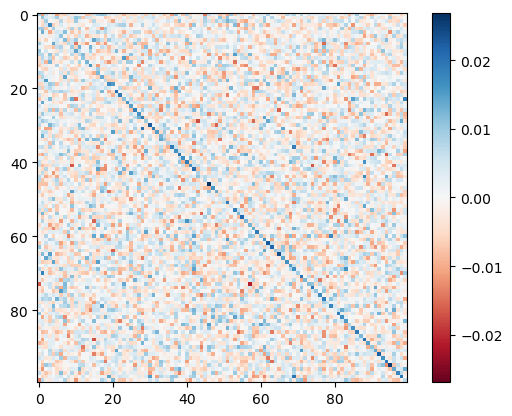

In [24]:
mean_jacobian = torch.stack(
        [wb['weight'] for wb in weights_and_biases]
    ).mean(dim=0)

visualize_matrix(mean_jacobian)

rank 300 >>  tensor(60.6522, device='cuda:0')


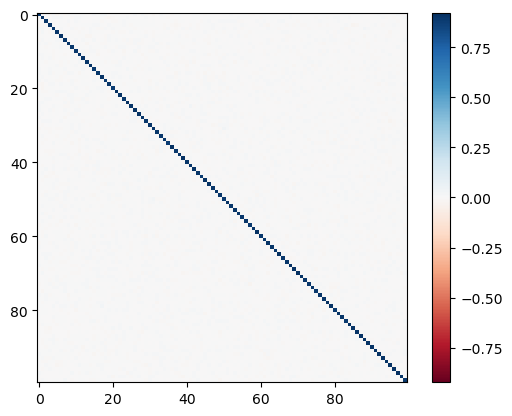

In [25]:
I = torch.eye(model.config.n_embd).to(model.dtype).to(model.device)
residual_add = mean_jacobian - I

residual_add_approx = low_rank_approximation(residual_add, rank = 300)
jacobian_approx = I + residual_add_approx
visualize_matrix(jacobian_approx)

In [26]:
relation_operator = estimate.RelationOperator(
    model = model,
    tokenizer= tokenizer,
    relation = prompt,
    layer = 15,
    weight = jacobian_approx,
    bias = grad_dsc_corner,

    # layer_name_format = "model.decoder.layers.{}",
    # ln_f_name = "model.decoder.final_layer_norm",
)

check_with_test_cases(relation_operator)

happy, target: happiest   ==>   predicted: [' happiest', ' quickest', ' richest', ' best', ' fastest']
hard, target: hardest   ==>   predicted: [' hardest', ' closest', ' poorest', ' lowest', ' toughest']
heavy, target: heaviest   ==>   predicted: [' heaviest', ' lowest', ' largest', ' hardest', ' weight']
high, target: highest   ==>   predicted: [' tallest', ' highest', ' largest', ' lowest', ' greatest']
hot, target: hottest   ==>   predicted: [' hottest', ' highest', ' lowest', ' fastest', ' largest']
large, target: largest   ==>   predicted: [' largest', ' lowest', ' smallest', ' biggest', ' greatest']
late, target: latest   ==>   predicted: [' latest', ' lowest', ' largest', ' longest', ' oldest']
long, target: longest   ==>   predicted: [' longest', ' tallest', ' shortest', ' largest', ' oldest']
low, target: lowest   ==>   predicted: [' lowest', ' poorest', ' smallest', ' tallest', ' cheapest']
near, target: nearest   ==>   predicted: [' smallest', ' lowest', ' nearest', ' least

In [27]:
import baukit

def untuple(x):
    if(isinstance(x, tuple)):
        return x[0]
    return x

def extract_zh(subject, relation, layer):
    prompt = relation.format(subject)
    inputs = tokenizer(
        prompt, return_tensors="pt", return_offsets_mapping=True
    ).to(model.device)
    offset_mapping = inputs.pop("offset_mapping")
    subject_i, subject_j = estimate.find_token_range(
        prompt, subject, offset_mapping=offset_mapping[0]
    )

    h_token_index = estimate.determine_token_index(subject_i, subject_j, -1)
    h_layer_name = f"transformer.h.{layer}"
    z_layer_name = f"transformer.h.{model.config.n_layer-1}"
    with baukit.TraceDict(
        model, [h_layer_name, z_layer_name]
    ) as traces:
        model(**inputs)

    return (
        untuple(traces[h_layer_name].output)[0, h_token_index], 
        untuple(traces[z_layer_name].output)[0, -1]
    )

h, z = extract_zh(
    subject = "large", relation=prompt,
    layer = 15
)

h.shape, z.shape

(torch.Size([4096]), torch.Size([4096]))

In [28]:
corner_estimator.get_vocab_representation(z)

[' largest', ' larg', ' biggest', ' greatest', ' larger']

In [29]:
z_jacobian = mean_jacobian.to(model.dtype) @ h + grad_dsc_corner
corner_estimator.get_vocab_representation(z_jacobian)

[' largest', ' biggest', ' smallest', ' widest', ' heaviest']

In [30]:
test_samples = [
        b for b, c, s in filter_single_token[:15]
    ]

sample_zh = [
    extract_zh(
        subject = s, relation = prompt, layer = 15
    ) for s in test_samples
]

sample_h = [h for h,z in sample_zh]
sample_z = [z for h,z in sample_zh]

sample_h = torch.stack(sample_h).T
sample_z = torch.stack(sample_z).T

sample_h.shape, sample_z.shape

(torch.Size([4096, 15]), torch.Size([4096, 15]))

In [31]:
# z = sample_h + (residual_add@sample_h.to(dtype)) + grad_dsc_corner[None].T
# z.shape

In [32]:
# logits = lm_head(z.T)
# logits.shape

In [33]:
# gather_indices = target_tokenized.input_ids.reshape(len(objects))
# gather_indices = torch.stack([gather_indices] * logits.shape[0])
# gather_indices.shape

In [34]:
# torch.gather(logits[3], 0, target_tokenized.input_ids.reshape(len(objects)))

In [35]:
# target_logits = torch.gather(logits, 1, gather_indices)

In [36]:
# distributions = torch.nn.functional.softmax(target_logits, dim = 1)
# distributions.shape

In [37]:
# # distributions.shape
# distributions.sum(dim = 1)

In [38]:
# target_tokenized = tokenizer(objects, padding=True, return_tensors="pt").to(model.device)

In [39]:
# lm_head = torch.nn.Sequential(
#                 model.transformer.ln_f,
#                 model.lm_head,
#             )

# h = sample_h[:, 4]
# z_true = h.to(dtype) + (residual_add@h.to(dtype)) + grad_dsc_corner.to(dtype)
# # corner_estimator.get_vocab_representation(z_true.to(model.dtype))
# logits_true = lm_head(z_true.to(model.dtype))

# distribution_true = torch.nn.functional.softmax(logits_true.to(dtype), dim = 0)
# distribution_true.sum(), distribution_true.shape

In [40]:
# z_est = h.to(dtype) + (projection@h.to(dtype)) + grad_dsc_corner.to(dtype)
# logits_est = lm_head(z_est.to(model.dtype))

# distribution_est = torch.nn.functional.softmax(logits_est.to(dtype), dim = 0)
# distribution_est.sum(), distribution_est.shape

In [41]:
# kl_loss = torch.nn.KLDivLoss(reduction="sum", log_target=True)
# loss = kl_loss(distribution_est, distribution_true)
# # loss = kl_loss(input = logits_est[:10].to(dtype), target = logits_true[:10].to(dtype))
# loss

In [42]:
# target_logits_true = torch.gather(logits_true, 0, target_tokenized.input_ids.reshape(len(objects)))
# target_logits_est = torch.gather(logits_est, 0, target_tokenized.input_ids.reshape(len(objects)))


# distribution_true = torch.nn.functional.softmax(target_logits_true.to(dtype), dim = 0)
# distribution_est = torch.nn.functional.softmax(target_logits_est.to(dtype), dim = 0)

In [43]:
# kl_loss = torch.nn.KLDivLoss(reduction="sum", log_target=True)

# loss = kl_loss(input = distribution_est, target = distribution_true)
# loss.item()

In [44]:
# logits_true.to(dtype).log_softmax(dim = 0).sum()

## Causal Basis Extraction

In [45]:
dtype = torch.float32

In [46]:
all_jacobians = [wb['bias'].to(dtype) for wb in weights_and_biases]
I = torch.eye(model.config.n_embd).to(model.dtype).to(model.device)

all_additionals = [(wb['bias'] - I).to(dtype) for wb in weights_and_biases]

mean_jacobian = torch.stack(
        [wb['weight'] for wb in weights_and_biases]
    ).mean(dim=0).to(dtype)

In [47]:
low_rank = 10

svd = mean_jacobian.svd()
svd.U.shape, svd.S.shape, svd.V.shape

(torch.Size([4096, 4096]), torch.Size([4096]), torch.Size([4096, 4096]))

In [48]:
causal_basis = svd.U[:low_rank].T.clone()
causal_basis.shape

torch.Size([4096, 10])

In [49]:
learning_rate = 5e-1
weight_decay = 2e-2
max_iter = 100
verbose = True

In [50]:
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [51]:
model.dtype

torch.float16

In [123]:
sample_h.shape, sample_z.shape

(torch.Size([4096, 15]), torch.Size([4096, 15]))

In [130]:

lm_head = torch.nn.Sequential(
            model.transformer.ln_f,
            model.lm_head,
        )

lm_head(sample_h[:, 10].to(model.dtype)).shape

torch.Size([50400])

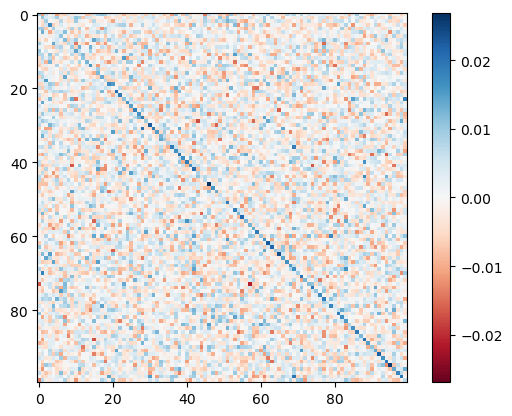

  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([4096, 0]) torch.Size([4096, 1])
torch.Size([4096, 1]) torch.Size([4096, 1])
torch.Size([4096, 2]) torch.Size([4096, 1])
torch.Size([4096, 3]) torch.Size([4096, 1])
torch.Size([4096, 4]) torch.Size([4096, 1])
torch.Size([4096, 5]) torch.Size([4096, 1])
torch.Size([4096, 6]) torch.Size([4096, 1])
torch.Size([4096, 7]) torch.Size([4096, 1])
torch.Size([4096, 8]) torch.Size([4096, 1])
torch.Size([4096, 9]) torch.Size([4096, 1])
torch.Size([4096, 10]) torch.Size([4096, 1])
torch.Size([4096, 11]) torch.Size([4096, 1])
torch.Size([4096, 12]) torch.Size([4096, 1])
torch.Size([4096, 13]) torch.Size([4096, 1])
torch.Size([4096, 14]) torch.Size([4096, 1])
torch.Size([4096, 15]) torch.Size([4096, 1])
torch.Size([4096, 16]) torch.Size([4096, 1])
torch.Size([4096, 17]) torch.Size([4096, 1])
torch.Size([4096, 18]) torch.Size([4096, 1])
torch.Size([4096, 19]) torch.Size([4096, 1])
torch.Size([4096, 20]) torch.Size([4096, 1])
torch.Size([4096, 21]) torch.Size([4096, 1])
torch.Size([4096, 22

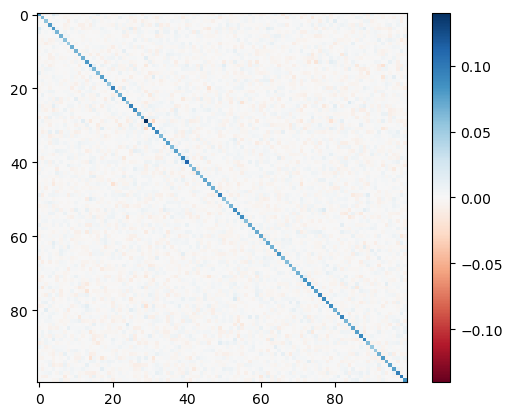

In [143]:
def causal_basis_extraction(
        matrix, sample_h, target_words, low_rank = 10, sample_z = None
    ):
    model.to(dtype)
    # mean_additional = torch.stack(all_additionals).mean(dim=0).to(dtype)
    visualize_matrix(matrix)
    svd = matrix.svd()
    causal_basis = svd.U[:low_rank].T.clone()
    # causal_basis = torch.zeros(model.config.n_embd, low_rank).to(dtype).to(model.device)

    lm_head = torch.nn.Sequential(
                model.transformer.ln_f,
                model.lm_head,
            )
    target_tokenized = tokenizer(target_words, padding=True, return_tensors="pt").to(model.device)
    # expected = matrix.to(dtype) @ sample_h
    # z_true = sample_h.to(dtype) + matrix.to(dtype) @ sample_h.to(dtype) + grad_dsc_corner.to(dtype)[None].T
    z_true = sample_z.to(dtype)
    logits_true = lm_head(z_true.T)
    gather_indices = target_tokenized.input_ids.reshape(len(objects))
    gather_indices = torch.stack([gather_indices] * logits_true.shape[0])
    target_logits_true = torch.gather(logits_true, 1, gather_indices)
    distribution_true = torch.nn.functional.softmax(target_logits_true, dim = 1)


    for r in tqdm(range(low_rank)):
        prev_basises = causal_basis[:, :r]
        cur_basis = Variable(causal_basis[:, r].clone()[None].T, requires_grad = True)
        # cur_basis = torch.FloatTensor(model.config.n_embd).uniform_(-1.001 , 1.001).to(dtype).to(model.device)[None].T
        cur_basis.requires_grad = True
        print(prev_basises.shape, cur_basis.shape)
        # print(cur_basis.shape, cur_basis.is_leaf)

        # because by design the basises are orthonormal to each other
        # https://en.wikipedia.org/wiki/Projection_(linear_algebra)#Properties_and_special_cases
        previous_basis_removal = I - (prev_basises @ prev_basises.T) 
        def remove_previous_basis(x):
            x = previous_basis_removal @ x
            # project to unit sphere
            return x/(x.norm() + torch.finfo(dtype).eps)

        def remove_subspace(x, subspace):
            """
            calculates the projection of `x` onto the span of the `subspace` and then removes it from x
            """
            projector = subspace @ subspace.T
            projection = projector @ x
            return x - projection
        
        optimizer = torch.optim.Adam(
            [cur_basis],
            lr=learning_rate,
            weight_decay=weight_decay,
        )
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)

        loss_track = []

        for epoch in range(max_iter):
            cur_basis_ = remove_previous_basis(x = cur_basis)
            cur_subspace = torch.cat((prev_basises, cur_basis), dim = 1)
            # projector = cur_subspace @ torch.linalg.solve(cur_subspace.mT @ cur_subspace, cur_subspace.mT) # A @ (A.T @ A).pinverse() @ A.T
            projector = cur_subspace @ cur_subspace.T
            # projection = cur_A @ (cur_A.T @ cur_A).pinverse() @ cur_A.T
            # predicted = projection @ sample_h
            # loss = (expected - predicted).square().sum()
            # loss = (matrix - projection).square().sum()

            orthogonal_projection = remove_subspace(sample_h, cur_subspace)
            orthogonal_mean = orthogonal_projection.mean(dim = 1)
            # print("orthogonal >> ", orthogonal_projection.shape, orthogonal_mean.shape)

            z_est = projector @ sample_h.to(dtype) + orthogonal_mean[None].T # + grad_dsc_corner.to(dtype)[None].T
            logits_est = lm_head(z_est.T)
            target_logits_est = torch.gather(logits_est, 1, gather_indices)
            distribution_est = torch.nn.functional.softmax(target_logits_est, dim = 1)

            loss = kl_loss(input = distribution_est, target = distribution_true)

            # print(loss)
            loss_track.append(loss.item())

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            cur_basis.grad.zero_()
        
        cur_basis.requires_grad = False
        cur_basis_ = remove_previous_basis(cur_basis)
        causal_basis[:, r] = torch.tensor([i.item() for i in cur_basis_])

        # if(verbose):
        #     plt.rcdefaults()
        #     plt.plot(loss_track)
        #     plt.xticks(range(0, len(loss_track), 10))
        #     plt.xlabel("Iteration")
        #     plt.ylabel("loss")
        #     plt.show()
        #     visualize_matrix(causal_basis[:, :r+1] @ causal_basis[:, :r+1].T)

    B = causal_basis
    # projector = B @ torch.linalg.solve(B.mT @ B, B.mT)
    projector = B @ B.T
    visualize_matrix(projector)

    orthogonal_projection = remove_subspace(sample_h, cur_subspace)
    orthogonal_mean = orthogonal_projection.mean(dim = 1)

    model.to(torch.float16)
    return B, projector, orthogonal_mean

basis, projector, orthogonal_mean = causal_basis_extraction(
    mean_jacobian, sample_h.to(dtype), target_words=objects,
    low_rank=300, sample_z=sample_z
)

In [141]:
torch.dist(projector, basis@basis.T)

tensor(0., device='cuda:0')

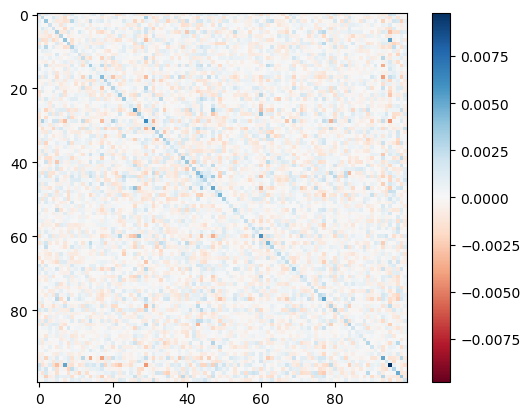

In [142]:
visualize_matrix(projector)

In [134]:
# mean_additional = torch.stack(all_additionals).mean(dim=0).to(dtype)
# residual_add = mean_jacobian - I
# visualize_matrix(residual_add)

In [135]:
# visualize_matrix(residual_add_approx)
print(grad_dsc_corner.norm())
corner_estimator.get_vocab_representation(grad_dsc_corner, get_logits=True)

tensor(50.2188, device='cuda:0', dtype=torch.float16)


[(' oldest', 53.438),
 (' richest', 52.0),
 (' closest', 50.875),
 (' fastest', 50.781),
 (' brightest', 50.562)]

In [136]:
print(orthogonal_mean.norm())
corner_estimator.get_vocab_representation(orthogonal_mean.to(model.dtype), get_logits=True)

tensor(302.3705, device='cuda:0', grad_fn=<CopyBackwards>)


[(' darkest', 20.234),
 (' highest', 12.391),
 (' darker', 11.18),
 (' dark', 10.867),
 (' colour', 10.789)]

In [137]:
print((grad_dsc_corner + orthogonal_mean).norm())
corner_estimator.get_vocab_representation((grad_dsc_corner + orthogonal_mean).to(model.dtype),  get_logits=True)

tensor(307.7746, device='cuda:0', grad_fn=<CopyBackwards>)


[(' darkest', 28.031),
 (' highest', 20.219),
 (' deepest', 17.094),
 (' heaviest', 16.594),
 (' brightest', 16.078)]

In [138]:
relation_operator = estimate.RelationOperator(
    model = model,
    tokenizer= tokenizer,
    relation = prompt,
    layer = 15,
    weight = projector.to(model.dtype),
    bias = (grad_dsc_corner + orthogonal_mean).to(model.dtype)
    # bias = torch.zeros(model.config.n_embd).to(model.dtype).to(model.device)

    # layer_name_format = "model.decoder.layers.{}",
    # ln_f_name = "model.decoder.final_layer_norm",
)

check_with_test_cases(relation_operator)

happy, target: happiest   ==>   predicted: [' darkest', ' highest', ' deepest', ' heaviest', ' brightest']
hard, target: hardest   ==>   predicted: [' darkest', ' highest', ' deepest', ' heaviest', ' brightest']
heavy, target: heaviest   ==>   predicted: [' darkest', ' highest', ' deepest', ' heaviest', ' brightest']
high, target: highest   ==>   predicted: [' darkest', ' highest', ' deepest', ' heaviest', ' brightest']
hot, target: hottest   ==>   predicted: [' darkest', ' highest', ' deepest', ' heaviest', ' brightest']
large, target: largest   ==>   predicted: [' darkest', ' highest', ' deepest', ' heaviest', ' brightest']
late, target: latest   ==>   predicted: [' darkest', ' highest', ' deepest', ' heaviest', ' brightest']
long, target: longest   ==>   predicted: [' darkest', ' highest', ' deepest', ' heaviest', ' brightest']
low, target: lowest   ==>   predicted: [' darkest', ' highest', ' deepest', ' heaviest', ' brightest']
near, target: nearest   ==>   predicted: [' darkest', 

In [56]:
relation_operator = estimate.RelationOperator(
    model = model,
    tokenizer= tokenizer,
    relation = prompt,
    layer = 15,
    weight = mean_jacobian.to(model.dtype),
    bias = grad_dsc_corner,

    # layer_name_format = "model.decoder.layers.{}",
    # ln_f_name = "model.decoder.final_layer_norm",
)

check_with_test_cases(relation_operator)

happy, target: happiest   ==>   predicted: [' happiest', ' richest', ' happy', ' best', ' brightest']
hard, target: hardest   ==>   predicted: [' hardest', ' toughest', ' easiest', ' strongest', ' closest']
heavy, target: heaviest   ==>   predicted: [' heaviest', ' darkest', ' hardest', ' richest', ' strongest']
high, target: highest   ==>   predicted: [' highest', ' tallest', ' lowest', ' richest', ' cheapest']
hot, target: hottest   ==>   predicted: [' hottest', ' coolest', ' hot', ' hardest', ' worst']
large, target: largest   ==>   predicted: [' largest', ' biggest', ' smallest', ' widest', ' heaviest']
late, target: latest   ==>   predicted: [' latest', ' earliest', ' newest', ' oldest', ' lowest']
long, target: longest   ==>   predicted: [' longest', ' shortest', ' oldest', ' tallest', ' earliest']
low, target: lowest   ==>   predicted: [' lowest', ' poorest', ' cheapest', ' weakest', ' smallest']
near, target: nearest   ==>   predicted: [' nearest', ' closest', ' oldest', ' shor